In [1]:
import torch
import numpy
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Create your tensors
all_values = torch.linspace(-5 * np.pi, 5 * np.pi, 1000).unsqueeze(1)
all_next_values = torch.sin(all_values)

# Create pairs (x, y)
data = torch.stack((all_values, all_next_values), dim=1)

# Shuffle the data
shuffled_indices = torch.randperm(len(data))
shuffled_data = data[shuffled_indices]

# Determine split indices
split_index = int(0.8 * len(shuffled_data))  # 80% for training

# Split into train and test sets
train_data = shuffled_data[:split_index]
test_data = shuffled_data[split_index:]


# def non_linear_transition(x, u):
#     x_prime = torch.sin(x) + u
#     reward = torch.sum(x_prime)
#     return(torch.sin(x), torch.tensor([reward]))
# train = []
# test = []
# N = 1000
# for i in range(N):  
#     x = torch.randn(1)
#     u = torch.tensor(random.uniform(-1, 1)).unsqueeze(0)
#     y, r = non_linear_transition(x, u)
#     if i % 10 == 0:
#         test.append((x, u, y, r))
#     else:
#         train.append((x, u, y, r))

In [3]:
enc_dim = 4
class LQR(nn.Module):
    def __init__(self, enc_dim):
        super(LQR, self).__init__()
        self.A = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        # self.B = torch.nn.Parameter(torch.randn(enc_dim, 1))
        # self.Q = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        # self.R = torch.nn.Parameter(torch.randn(1, 1))
       
        self.state_encoder = torch.nn.Sequential(
            torch.nn.Linear(1, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.state_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, 1)
        )
    def forward (self,x):
        #QQ = self.Q.T @ self.Q #PSD
        #RR = self.R.T @ self.R
        xx = self.state_encoder(x)
        x_prime_prediction = self.A @ xx #+ self.B @ u
        #reward = -1 * (xx.T @ QQ @ xx + u.T @ RR @ u)
        return self.state_decoder(x_prime_prediction), x_prime_prediction, xx, #reward.unsqueeze(0)
model = LQR(enc_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
#train, test are lists of tuples of (x, u, y, r)
def train_model(epochs=2000,enc_dim=4):
    model = LQR(enc_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    for i in range(epochs):
        total_state_loss = 0
        total_reward_loss = 0
        for x, y in train_data:
            optimizer.zero_grad()
            lqr_x_prime, x_prime_expanded, xx = model(x)
            #reward_loss = criterion(reward, r)
            lqr_pred_loss = criterion(lqr_x_prime, y)
            decoder_loss = criterion(model.state_decoder(xx), x)
            encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
            state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
            loss = state_loss #+ reward_loss
            loss.backward()
            optimizer.step()
            total_state_loss += state_loss.item()
            total_reward_loss += 0#reward_loss.item()
        if i % 10 == 0:
            with torch.no_grad():
                total_test_state_loss = 0
                total_test_reward_loss = 0
                for x, y, in test_data:
                    lqr_x_prime, x_prime_expanded, xx, = model(x)
                    #reward_loss = criterion(reward, r)
                    lqr_pred_loss = criterion(lqr_x_prime, y)
                    decoder_loss = criterion(model.state_decoder(xx), x)
                    encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
                    state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
                    total_test_state_loss += state_loss.item()
                    total_test_reward_loss += 0#reward_loss.item()
                print(f"Epoch {i}, Train State Loss: {total_state_loss}, Train Reward Loss: {total_reward_loss}, Test State Loss: {total_test_state_loss}, Test Reward Loss: {total_test_reward_loss}")
    test_predictions = []
    with torch.no_grad():
        for x, y in test_data:
            lqr_x_prime, x_prime_expanded, xx = model(x)
            test_predictions.append(lqr_x_prime)
    #save model
    torch.save(model.state_dict(), f'encoder_dim_{enc_dim}.pt')
    #scatter
    plt.scatter(test_data[:, 0], test_predictions, c='r', alpha=0.5)
    plt.scatter(test_data[:, 0], test_data[:, 1], c='b',alpha=0.5)
    plt.legend(['Predicted', 'Actual'])
    plt.title(f'Encoder Dimension: {enc_dim}')
    plt.show()
    #save plot
    plt.savefig(f'encoder_dim_{enc_dim}.png')
    return model

c:\Users\mikef\anaconda3\envs\gym\lib\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch 0, Train State Loss: 66426.67941925046, Train Reward Loss: 0, Test State Loss: 16495.753404813353, Test Reward Loss: 0
Epoch 10, Train State Loss: 66419.547361042, Train Reward Loss: 0, Test State Loss: 16499.849012698047, Test Reward Loss: 0
Epoch 20, Train State Loss: 66419.36691290687, Train Reward Loss: 0, Test State Loss: 16500.625671530048, Test Reward Loss: 0
Epoch 30, Train State Loss: 66419.34301293339, Train Reward Loss: 0, Test State Loss: 16500.764134522222, Test Reward Loss: 0
Epoch 40, Train State Loss: 66419.3388870738, Train Reward Loss: 0, Test State Loss: 16500.78863389051, Test Reward Loss: 0
Epoch 50, Train State Loss: 66419.33829293656, Train Reward Loss: 0, Test State Loss: 16500.793130825143, Test Reward Loss: 0
Epoch 60, Train State Loss: 66419.33822180459, Train Reward Loss: 0, Test State Loss: 16500.793759078064, Test Reward Loss: 0
Epoch 70, Train State Loss: 66419.33786994196, Train Reward Loss: 0, Test State Loss: 16500.793942710756, Test Reward Loss:

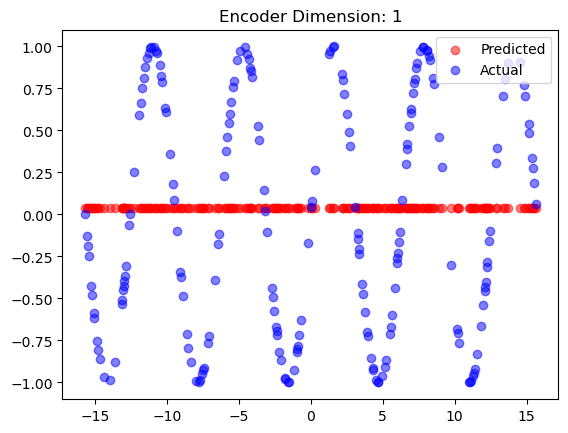

Epoch 0, Train State Loss: 67931.89865878224, Train Reward Loss: 0, Test State Loss: 16787.377727508545, Test Reward Loss: 0
Epoch 10, Train State Loss: 66436.57563992497, Train Reward Loss: 0, Test State Loss: 16523.062935294583, Test Reward Loss: 0
Epoch 20, Train State Loss: 66419.43773679389, Train Reward Loss: 0, Test State Loss: 16504.113672585285, Test Reward Loss: 0
Epoch 30, Train State Loss: 23484.565349239856, Train Reward Loss: 0, Test State Loss: 6145.095509488136, Test Reward Loss: 0
Epoch 40, Train State Loss: 9221.946740977466, Train Reward Loss: 0, Test State Loss: 2452.610254936735, Test Reward Loss: 0
Epoch 50, Train State Loss: 3341.8060782812536, Train Reward Loss: 0, Test State Loss: 906.0747278425843, Test Reward Loss: 0
Epoch 60, Train State Loss: 1305.5806680943933, Train Reward Loss: 0, Test State Loss: 369.33350872044684, Test Reward Loss: 0
Epoch 70, Train State Loss: 696.8277402421081, Train Reward Loss: 0, Test State Loss: 209.16311680496437, Test Reward L

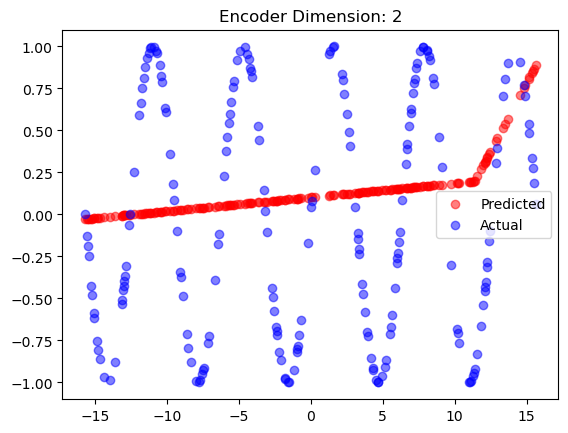

Epoch 0, Train State Loss: 45207.1093005985, Train Reward Loss: 0, Test State Loss: 9004.498502378352, Test Reward Loss: 0
Epoch 10, Train State Loss: 14484.351178515702, Train Reward Loss: 0, Test State Loss: 3817.5215209703892, Test Reward Loss: 0
Epoch 20, Train State Loss: 5705.023727892898, Train Reward Loss: 0, Test State Loss: 1529.416541280225, Test Reward Loss: 0
Epoch 30, Train State Loss: 2190.3856818417553, Train Reward Loss: 0, Test State Loss: 590.1317140457686, Test Reward Loss: 0
Epoch 40, Train State Loss: 886.4834960214794, Train Reward Loss: 0, Test State Loss: 242.93269200623035, Test Reward Loss: 0
Epoch 50, Train State Loss: 523.3047971851192, Train Reward Loss: 0, Test State Loss: 145.89306709263474, Test Reward Loss: 0
Epoch 60, Train State Loss: 429.2274143565446, Train Reward Loss: 0, Test State Loss: 117.15766870556399, Test Reward Loss: 0
Epoch 70, Train State Loss: 399.3389429207891, Train Reward Loss: 0, Test State Loss: 105.47181835700758, Test Reward Los

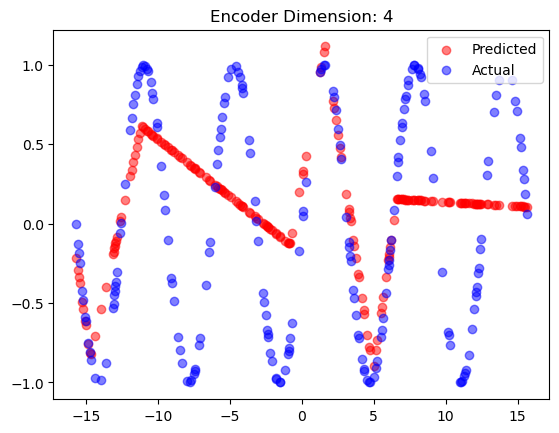

Epoch 0, Train State Loss: 25711.035128757358, Train Reward Loss: 0, Test State Loss: 181.68942870944738, Test Reward Loss: 0
Epoch 10, Train State Loss: 361.90473908628337, Train Reward Loss: 0, Test State Loss: 81.27470648940653, Test Reward Loss: 0
Epoch 20, Train State Loss: 301.4559556846507, Train Reward Loss: 0, Test State Loss: 69.9888158030808, Test Reward Loss: 0
Epoch 30, Train State Loss: 284.21520270127803, Train Reward Loss: 0, Test State Loss: 67.73667231854051, Test Reward Loss: 0
Epoch 40, Train State Loss: 262.52672505844384, Train Reward Loss: 0, Test State Loss: 62.58057721471414, Test Reward Loss: 0
Epoch 50, Train State Loss: 249.57556138723157, Train Reward Loss: 0, Test State Loss: 56.105585236800835, Test Reward Loss: 0
Epoch 60, Train State Loss: 226.1408654632978, Train Reward Loss: 0, Test State Loss: 62.555328386835754, Test Reward Loss: 0
Epoch 70, Train State Loss: 201.43442827602848, Train Reward Loss: 0, Test State Loss: 47.52793858759105, Test Reward L

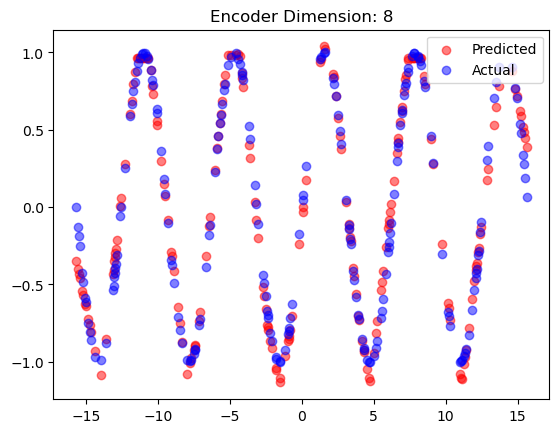

Epoch 0, Train State Loss: 19543.24746645242, Train Reward Loss: 0, Test State Loss: 204.98922754824162, Test Reward Loss: 0
Epoch 10, Train State Loss: 376.6514479946345, Train Reward Loss: 0, Test State Loss: 95.60101690143347, Test Reward Loss: 0
Epoch 20, Train State Loss: 300.2898385147564, Train Reward Loss: 0, Test State Loss: 78.57895558187738, Test Reward Loss: 0
Epoch 30, Train State Loss: 284.3874430919532, Train Reward Loss: 0, Test State Loss: 80.24906863458455, Test Reward Loss: 0
Epoch 40, Train State Loss: 265.66506705235224, Train Reward Loss: 0, Test State Loss: 63.707743152743205, Test Reward Loss: 0
Epoch 50, Train State Loss: 249.0829562745057, Train Reward Loss: 0, Test State Loss: 58.447925391141325, Test Reward Loss: 0
Epoch 60, Train State Loss: 131.89546708972193, Train Reward Loss: 0, Test State Loss: 28.554480680264533, Test Reward Loss: 0
Epoch 70, Train State Loss: 97.91142939054407, Train Reward Loss: 0, Test State Loss: 20.075753920245916, Test Reward Lo

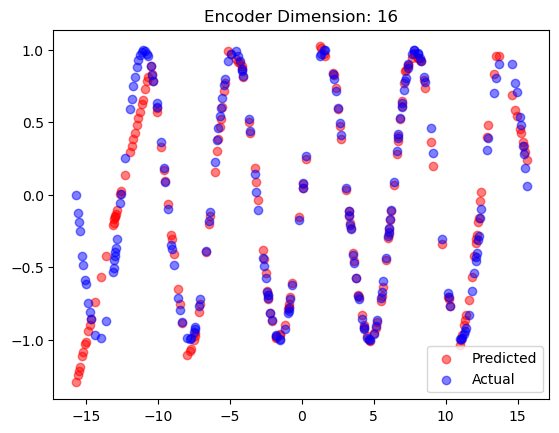

Epoch 0, Train State Loss: 13234.613950908184, Train Reward Loss: 0, Test State Loss: 137.03616721183062, Test Reward Loss: 0
Epoch 10, Train State Loss: 352.9815555214882, Train Reward Loss: 0, Test State Loss: 65.84940939489752, Test Reward Loss: 0
Epoch 20, Train State Loss: 290.1853174143471, Train Reward Loss: 0, Test State Loss: 57.712661186698824, Test Reward Loss: 0
Epoch 30, Train State Loss: 208.30380819365382, Train Reward Loss: 0, Test State Loss: 41.693117855582386, Test Reward Loss: 0
Epoch 40, Train State Loss: 177.2945602843538, Train Reward Loss: 0, Test State Loss: 39.01887740707025, Test Reward Loss: 0
Epoch 50, Train State Loss: 139.99194606393576, Train Reward Loss: 0, Test State Loss: 20.964657608885318, Test Reward Loss: 0
Epoch 60, Train State Loss: 97.96013177011628, Train Reward Loss: 0, Test State Loss: 35.300296103581786, Test Reward Loss: 0
Epoch 70, Train State Loss: 74.79817031871062, Train Reward Loss: 0, Test State Loss: 15.316267904359847, Test Reward 

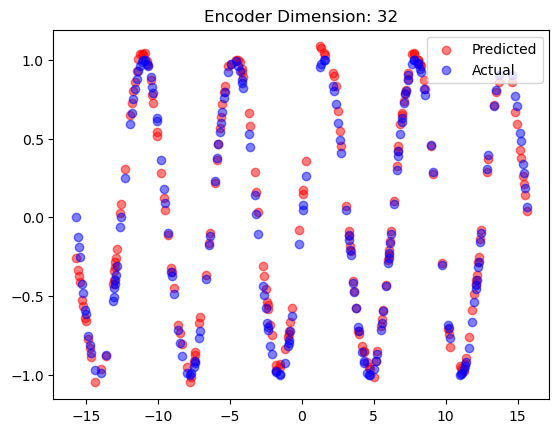

Epoch 0, Train State Loss: 8723.989213399589, Train Reward Loss: 0, Test State Loss: 161.65072245895863, Test Reward Loss: 0
Epoch 10, Train State Loss: 467.64652533410117, Train Reward Loss: 0, Test State Loss: 78.86804874427617, Test Reward Loss: 0
Epoch 20, Train State Loss: 327.68335669580847, Train Reward Loss: 0, Test State Loss: 69.00160711631179, Test Reward Loss: 0
Epoch 30, Train State Loss: 272.8358714003116, Train Reward Loss: 0, Test State Loss: 67.73109742999077, Test Reward Loss: 0
Epoch 40, Train State Loss: 181.8311430248432, Train Reward Loss: 0, Test State Loss: 27.062689814716578, Test Reward Loss: 0
Epoch 50, Train State Loss: 123.79494524374604, Train Reward Loss: 0, Test State Loss: 28.934281827881932, Test Reward Loss: 0
Epoch 60, Train State Loss: 114.97702089999802, Train Reward Loss: 0, Test State Loss: 29.15785790933296, Test Reward Loss: 0
Epoch 70, Train State Loss: 100.97609520552214, Train Reward Loss: 0, Test State Loss: 37.428252793848515, Test Reward 

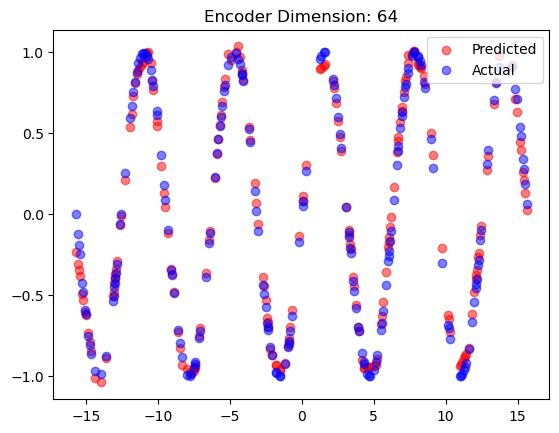

Epoch 0, Train State Loss: 9568.88033387065, Train Reward Loss: 0, Test State Loss: 423.42081195116043, Test Reward Loss: 0
Epoch 10, Train State Loss: 341.81870639976114, Train Reward Loss: 0, Test State Loss: 93.26929841935635, Test Reward Loss: 0
Epoch 20, Train State Loss: 395.6121736615896, Train Reward Loss: 0, Test State Loss: 68.21261696703732, Test Reward Loss: 0
Epoch 30, Train State Loss: 305.181408170145, Train Reward Loss: 0, Test State Loss: 62.6647918317467, Test Reward Loss: 0
Epoch 40, Train State Loss: 327.23288144823164, Train Reward Loss: 0, Test State Loss: 68.27307766024023, Test Reward Loss: 0
Epoch 50, Train State Loss: 291.51780114276335, Train Reward Loss: 0, Test State Loss: 66.46590568497777, Test Reward Loss: 0
Epoch 60, Train State Loss: 241.58264081086963, Train Reward Loss: 0, Test State Loss: 50.57966666389257, Test Reward Loss: 0
Epoch 70, Train State Loss: 195.68611551402137, Train Reward Loss: 0, Test State Loss: 44.91655891388655, Test Reward Loss: 

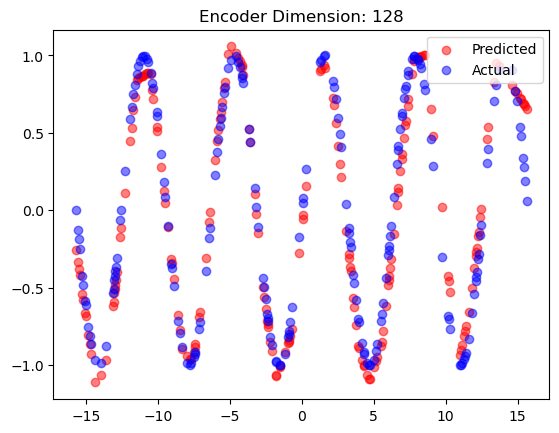

<Figure size 640x480 with 0 Axes>

In [9]:
enc_dims = [1, 2, 4, 8, 16,32,64,128] 
for enc_dim in enc_dims:
    train_model(2000,enc_dim)

In [ ]:
#start with just sin, then just make R and A very simple and see how well K can do

Epoch 0, Train State Loss: 8772.952046081424, Train Reward Loss: 0, Test State Loss: 142.69397947192192, Test Reward Loss: 0
Epoch 10, Train State Loss: 414.5914226984605, Train Reward Loss: 0, Test State Loss: 69.99741734936833, Test Reward Loss: 0
Epoch 20, Train State Loss: 363.9901124299504, Train Reward Loss: 0, Test State Loss: 69.06962721887976, Test Reward Loss: 0
Epoch 30, Train State Loss: 247.39842818537727, Train Reward Loss: 0, Test State Loss: 55.98556073196232, Test Reward Loss: 0
Epoch 40, Train State Loss: 196.1564989327453, Train Reward Loss: 0, Test State Loss: 46.96609127987176, Test Reward Loss: 0
Epoch 50, Train State Loss: 127.02295886538923, Train Reward Loss: 0, Test State Loss: 24.50532284192741, Test Reward Loss: 0
Epoch 60, Train State Loss: 92.80038158572279, Train Reward Loss: 0, Test State Loss: 25.350390524603426, Test Reward Loss: 0
Epoch 70, Train State Loss: 90.03709508385509, Train Reward Loss: 0, Test State Loss: 35.23393042944372, Test Reward Loss:

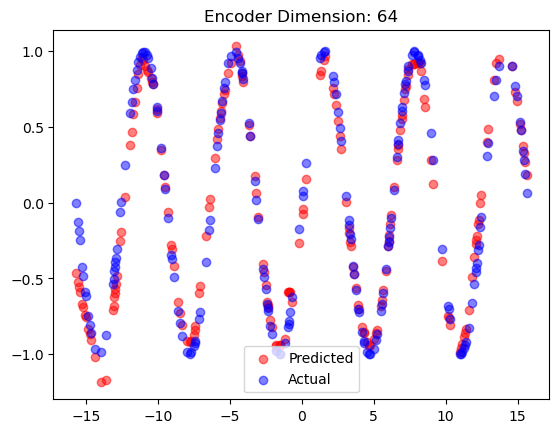

<Figure size 640x480 with 0 Axes>

In [19]:
model_64 = train_model(1000,64)

In [17]:
type(model_64)

__main__.LQR

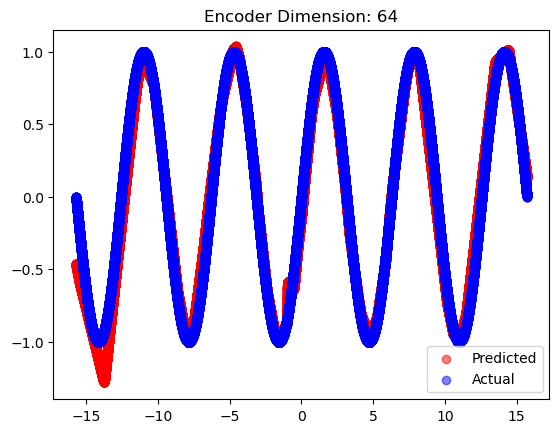

In [27]:
super_values = torch.linspace(-5 * np.pi, 5*np.pi, 100000).unsqueeze(1)
all_next_super_values = torch.sin(super_values)
super_data = torch.stack((super_values, all_next_super_values), dim=1)
test_predictions = []
with torch.no_grad():
    for x, y in super_data:
        lqr_x_prime, x_prime_expanded, xx = model_64(x)
        test_predictions.append(lqr_x_prime)

#scatter
plt.scatter(super_data[:, 0], test_predictions, c='r', alpha=0.5)
plt.scatter(super_data[:, 0], super_data[:, 1], c='b',alpha=0.5)
plt.legend(['Predicted', 'Actual'])
plt.title(f'Encoder Dimension: {64}')
plt.show()

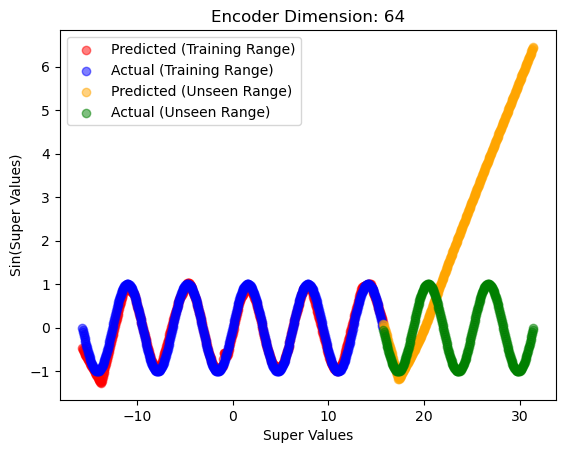

In [22]:

# Generate the data
super_values = torch.linspace(-5 * np.pi, 10 * np.pi, 1000).unsqueeze(1)
all_next_super_values = torch.sin(super_values)
super_data = torch.cat((super_values, all_next_super_values), dim=1)

# Split data into ranges
range_1_mask = (super_values.squeeze() >= -5 * np.pi) & (super_values.squeeze() <= 5 * np.pi)
range_2_mask = (super_values.squeeze() > 5 * np.pi)

range_1_values = super_values[range_1_mask]
range_1_actual = all_next_super_values[range_1_mask]
range_2_values = super_values[range_2_mask]
range_2_actual = all_next_super_values[range_2_mask]

test_predictions = []
with torch.no_grad():
    for x, y in super_data:
        lqr_x_prime, x_prime_expanded, xx = model_64(x.unsqueeze(0))
        test_predictions.append(lqr_x_prime)
test_predictions = torch.tensor(test_predictions)

# Scatter plot
plt.scatter(
    range_1_values, 
    test_predictions[range_1_mask], 
    c='r', alpha=0.5, label="Predicted (Training Range)"
)
plt.scatter(
    range_1_values, 
    range_1_actual, 
    c='b', alpha=0.5, label="Actual (Training Range)"
)

plt.scatter(
    range_2_values, 
    test_predictions[range_2_mask], 
    c='orange', alpha=0.5, label="Predicted (Unseen Range)"
)
plt.scatter(
    range_2_values, 
    range_2_actual, 
    c='green', alpha=0.5, label="Actual (Unseen Range)"
)

# Add legend and labels
plt.legend()
plt.title(f'Encoder Dimension: {64}')
plt.xlabel('Super Values')
plt.ylabel('Sin(Super Values)')
plt.show()
